Iteration 1
  Local Best Positions and Values:
    Particle 0: Position [-0.55881112  1.27370579], Value 1.9345963089991112
    Particle 1: Position [-0.36395307  1.11648712], Value 1.3790053371132274
    Particle 2: Position [-3.91349176 -3.38295568], Value 26.759806858436868
    Particle 3: Position [-0.10862461  0.18378689], Value 0.0455769247230102
    Particle 4: Position [-0.80698506  1.27338868], Value 2.2727436282630733
    Particle 5: Position [ 3.08792751 -1.5450635 ], Value 11.922517539019568
    Particle 6: Position [ 0.94107894 -0.35918863], Value 1.0146460517525742
    Particle 7: Position [ 0.6427553  -0.71505171], Value 0.9244333205996178
    Particle 8: Position [4.60526729 2.01075271], Value 25.251613333594555
    Particle 9: Position [ 3.09322908 -1.54643244], Value 11.959519437094839
    Particle 10: Position [-1.90191989 -1.29974859], Value 5.306645668219325
    Particle 11: Position [-2.583767    1.22523736], Value 8.177058487612534
    Particle 12: Position [ 0.4

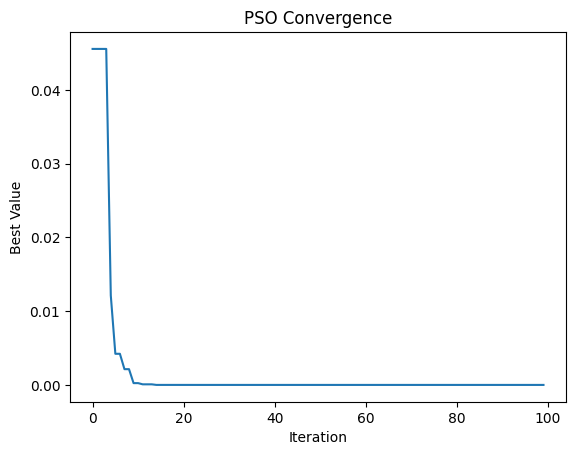

In [22]:
import numpy as np

# PSO Parameters
SWARM_SIZE = 30    # Number of particles
DIMENSIONS = 2     # Number of dimensions
MAX_ITERATIONS = 100  # Maximum number of iterations
W = 0.5    # Inertia weight
C1 = 1.5   # Cognitive coefficient
C2 = 1.5   # Social coefficient
RANGE = 5.0  # Range for initializing particle positions
BOUND_LOW = -RANGE
BOUND_HIGH = RANGE

# Objective function to minimize
def objective_function(x):
    return np.sum(x ** 2)

def pso_algorithm():
    # Initialize particles
    swarm = np.random.uniform(BOUND_LOW, BOUND_HIGH, (SWARM_SIZE, DIMENSIONS))
    velocities = np.random.uniform(-RANGE, RANGE, (SWARM_SIZE, DIMENSIONS))
    personal_best_positions = np.copy(swarm)
    personal_best_values = np.apply_along_axis(objective_function, 1, swarm)
    
    global_best_index = np.argmin(personal_best_values)
    global_best_position = personal_best_positions[global_best_index]
    global_best_value = personal_best_values[global_best_index]

    best_values_over_time = []
    
    for t in range(MAX_ITERATIONS):
        # Update velocities and positions
        r1, r2 = np.random.rand(SWARM_SIZE, DIMENSIONS), np.random.rand(SWARM_SIZE, DIMENSIONS)
        velocities = (W * velocities +
                      C1 * r1 * (personal_best_positions - swarm) +
                      C2 * r2 * (global_best_position - swarm))
        swarm += velocities
        
        # Apply boundary conditions
        swarm = np.clip(swarm, BOUND_LOW, BOUND_HIGH)
        
        # Evaluate fitness
        fitness_values = np.apply_along_axis(objective_function, 1, swarm)
        
        # Update personal bests
        better_mask = fitness_values < personal_best_values
        personal_best_positions[better_mask] = swarm[better_mask]
        personal_best_values[better_mask] = fitness_values[better_mask]
        
        # Update global best
        current_best_index = np.argmin(personal_best_values)
        current_best_value = personal_best_values[current_best_index]
        if current_best_value < global_best_value:
            global_best_position = personal_best_positions[current_best_index]
            global_best_value = current_best_value

        # Track the best value over time
        best_values_over_time.append(global_best_value)
        
        print(f"Iteration {t+1}")
        print("  Local Best Positions and Values:")
        for i in range(SWARM_SIZE):
            print(f"    Particle {i}: Position {personal_best_positions[i]}, Value {personal_best_values[i]}")
        print("  Global Best Position and Value:")
        print(f"    Global Best Position: {global_best_position}, Global Best Value: {global_best_value}\n")
        
    return global_best_position, global_best_value, best_values_over_time

if __name__ == "__main__":
    best_position, best_value, best_values_over_time = pso_algorithm()
    print("Final Best Position:", best_position)
    print("Final Best Value:", best_value)
    
    
    import matplotlib.pyplot as plt
    plt.plot(best_values_over_time)
    plt.xlabel('Iteration')
    plt.ylabel('Best Value')
    plt.title('PSO Convergence')
    plt.show()


In [23]:
pip install numpy opencv-python scipy



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
import numpy as np
import cv2
from scipy.stats import entropy
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt


In [25]:
def otsu_multilevel_threshold(image, thresholds):
    thresholds = np.sort(thresholds).astype(int)
    thresholds = np.concatenate(([0], thresholds, [255]))
    thresholds = np.unique(thresholds)
    
    def between_class_variance(histogram):
        total = np.sum(histogram)
        sum_total = np.sum(np.arange(256) * histogram)
        sum_bg = 0
        weight_bg = 0
        max_variance = 0
        for i in range(len(thresholds) - 1):
            weight_fg = np.sum(histogram[thresholds[i]+1:thresholds[i+1]])
            sum_bg += np.sum(histogram[:thresholds[i]+1] * np.arange(thresholds[i]+1))
            if weight_fg == 0 or weight_bg == 0:
                continue
            mean_bg = sum_bg / weight_bg
            mean_fg = (sum_total - sum_bg) / weight_fg
            variance = weight_bg * weight_fg * (mean_bg - mean_fg) ** 2
            if variance > max_variance:
                max_variance = variance
        return -max_variance
    
    hist = cv2.calcHist([image], [0], None, [256], [0, 256]).flatten()
    return between_class_variance(hist)


In [26]:

def pso_optimization(image, num_thresholds, max_iter=100):
    from pyswarm import pso
    
    def objective_function(thresholds):
        thresholds = np.sort(thresholds)
        if np.any(thresholds < 0) or np.any(thresholds > 255):
            return np.inf
        return otsu_multilevel_threshold(image, thresholds)
    
    lb = [0] * num_thresholds
    ub = [255] * num_thresholds
    optimal_thresholds, _ = pso(objective_function, lb, ub, maxiter=max_iter)
    return np.sort(optimal_thresholds)


Stopping search: maximum iterations reached --> 100


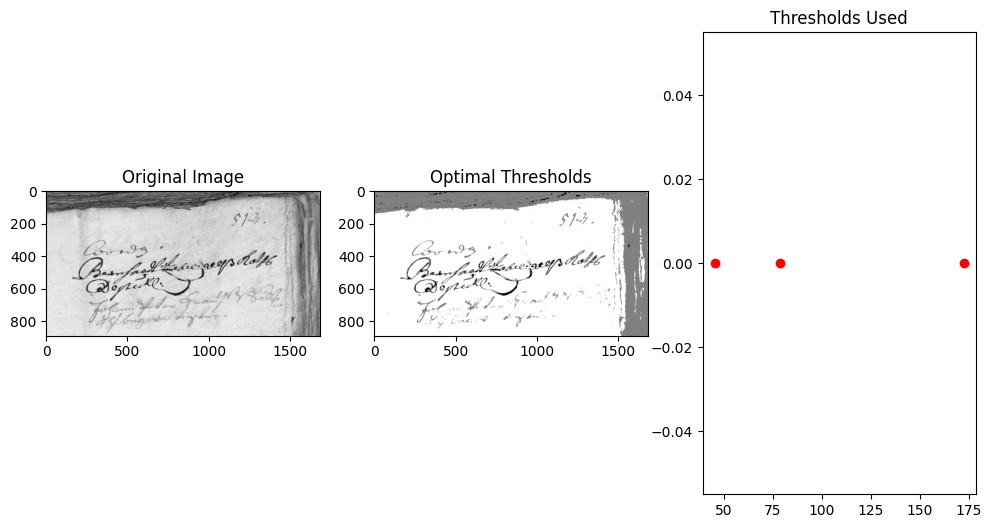

In [29]:
def apply_threshold(image, thresholds):
    thresholds = np.sort(thresholds).astype(int)
    thresholds = np.concatenate(([0], thresholds, [255]))
    thresholds = np.unique(thresholds)
    
    segmented_image = np.digitize(image, bins=thresholds, right=True)
    return segmented_image

# Load image
image = cv2.imread('./dataset/5.BMP', cv2.IMREAD_GRAYSCALE)

num_thresholds = 3

# Find optimal thresholds
optimal_thresholds = pso_optimization(image, num_thresholds)

# Apply thresholds to the image
segmented_image = apply_threshold(image, optimal_thresholds)

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Optimal Thresholds')
plt.imshow(segmented_image, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Thresholds Used')
plt.plot(optimal_thresholds, [0]*len(optimal_thresholds), 'ro')
plt.show()
